### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## it's my meshmask i can cry if i want to

511207893.3958111
511207893395810.94


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


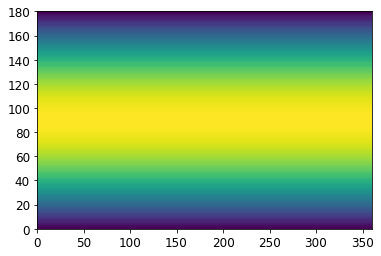

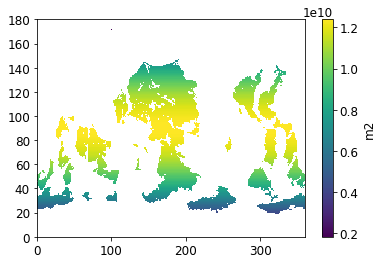

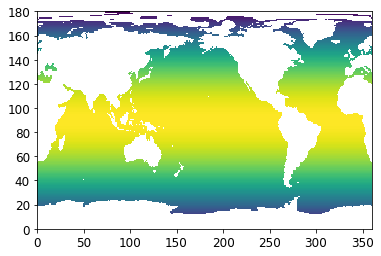

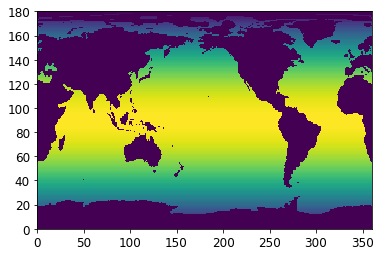

In [4]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
t2 = glob.glob(f'{tdir}TAlk_umolL.nc')
Talk = xr.open_dataset(t2[0])

from area import area
obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}
w = area(obj)
print(w/1e6)

calc_ar = np.zeros([180,360])

lats = (Talk.lat.values)
lons = (Talk.lon.values)-20

# print(lats)
# print(lons)

for lat in range(0,180):
    for lon in range(0,360):
        
        tlat = lats[lat]
        ll_lat = tlat - 0.5
        ul_lat = tlat + 0.5
        ur_lat = tlat + 0.5
        lr_lat = tlat - 0.5
        
        tlon = lons[lon] - 180 + 0.5
        ll_lon = tlon - 0.5
        ul_lon = tlon - 0.5
        ur_lon = tlon + 0.5
        lr_lon = tlon + 0.5
        
        lats_poly = [ll_lat, ul_lat, ur_lat, lr_lat]
        lons_poly = [ll_lon, ul_lon, ur_lon, lr_lon]
        
        #calc_ar[lat, lon] = polygon_area(lats_poly, lons_poly)
        obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}
        obj = {'type':'Polygon','coordinates':[[[ll_lon,ll_lat],[ul_lon,ul_lat],[ur_lon,ur_lat],[lr_lon,lr_lat],[ll_lon,ll_lat]]]}
        #obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}

        calc_ar[lat, lon] = area(obj)
        
#         if (lat%10 == 0) & (lon%10 == 0):
#             print(f'{tlat}, {tlon}, {calc_ar[lat, lon]}')

        
plt.figure()
plt.pcolormesh(calc_ar)
print(np.nansum(calc_ar))



calc_ar_3d = np.zeros([33,180,360])
for i in range(0,33):
    calc_ar_3d[i,:,:] = calc_ar

calc_ar_3d[np.isnan(Talk.Reconstructed_DIC)] = np.nan

plt.figure()
q = plt.pcolormesh(calc_ar_3d[30,:,:])
plt.colorbar(q, label = 'm2')

calc_ar_dar = Talk.Reconstructed_DIC.copy(deep = True)
calc_ar_dar.data = calc_ar_3d
plt.figure()
plt.pcolormesh(calc_ar_dar[0,:,:])
calc_ar_dar = calc_ar_dar.fillna(0)
plt.figure()
plt.pcolormesh(calc_ar_dar[0,:,:])


<xarray.Dataset>
Dimensions:   (depth: 33, lat: 180, lon: 360)
Coordinates:
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
Data variables:
    Anth_DIC  (depth, lat, lon) float64 ...
Attributes:
    made in:  SOZONE/Tuning/glodap_umolL_restart.ipynb


Text(0.5, 0.98, 'glodap SO DIC and TA and anth DIC, year 2002, umol/L')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


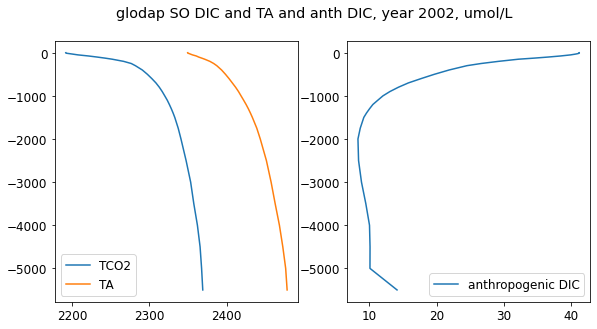

In [5]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
t2 = glob.glob(f'{tdir}TAlk_umolL.nc')
t3 = glob.glob(f'{tdir}AnthDIC_ssp1_2002_umolL.nc')
t4 = glob.glob(f'{tdir}EstimatedDIC_ssp1_2002_umolL.nc')

Talk = xr.open_dataset(t2[0])
Cant = xr.open_dataset(t3[0])
TCO2 = xr.open_dataset(t4[0])

print(Cant)

TA_mean = Talk.Reconstructed_DIC[:,0:40,:].weighted(calc_ar_dar[:,0:40,:]).mean(dim = ['lat','lon'])
Cant_mean = Cant.Anth_DIC[:,0:40,:].weighted(calc_ar_dar[:,0:40,:]).mean(dim = ['lat','lon'])
TCO2_mean = TCO2.Reconstructed_DIC[:,0:40,:].weighted(calc_ar_dar[:,0:40,:]).mean(dim = ['lat','lon'])

fact = 0.8
fig, axs = plt.subplots(1,2, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(TCO2_mean,-Cant.depth, label = 'TCO2')
axs[0].plot(TA_mean,-Cant.depth, label = 'TA')
axs[1].plot(Cant_mean,-Cant.depth, label = 'anthropogenic DIC')

axs[0].legend()
axs[1].legend()

plt.suptitle('glodap SO DIC and TA and anth DIC, year 2002, umol/L')

In [6]:
TA_mean[0]

<xarray.DataArray 'Reconstructed_DIC' ()>
array(2349.51722732)
Coordinates:
    depth    float64 0.0

## function to get S and T out of glodap

In [7]:
## get salt, temp

def get_ts(yr, scen):
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/'

    if yr < 2015:
        runid = 'bc370'
    else:
        if scen == '1A':
            runid = 'be682'
        if scen == '1B':
            runid = 'ce417'

    #bgc = xr.open_dataset(f'{tdir}medusa_{runid}_1y_{yr}_ptrc-T-CHLTADIC.nc')
    ts = xr.open_dataset(f'{tdir}nemo_{runid}_1y_{yr}_grid-T-TS.nc')
    #diadaux = xr.open_dataset(f'{tdir}medusa_{runid}_1y_{yr}_diad-T-aux.nc')
    
    tmask = xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask.nc')
    tmask_surf = tmask.tmask[0,0,:,:] * tmask.e1t[0,:,:] * tmask.e2t[0,:,:]
    
    T_mean = ts.votemper.isel(y=slice(0,114),deptht = 0).\
    weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y']).mean().values
    S_mean = ts.vosaline.isel(y=slice(0,114),deptht = 0).\
    weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y']).mean().values
    return T_mean, S_mean #bgc, ts, diadaux

T_mean, S_mean = get_ts(2002, '1A')
print(T_mean)
print(S_mean)

T_mean, S_mean = get_ts(2002, '1B')
print(T_mean)
print(S_mean)


1.6878149577590982
33.86606849724443
1.6878149577590982
33.86606849724443


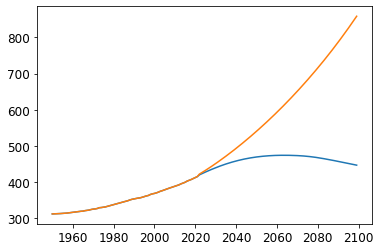

In [8]:
co2_ssp1 = '/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat'
co2_ssp3 = '/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70.dat'

atmo_co2_ssp1 = pd.read_csv(co2_ssp1, sep='\t')
atmo_co2_ssp3 = pd.read_csv(co2_ssp3, sep='\t')



yr = atmo_co2_ssp1['1650.042'].values
co2atm_ssp1 = atmo_co2_ssp1['276.58'].values
co2atm_ssp3 = atmo_co2_ssp3['276.58'].values


yrmns = np.arange(1950,2100,1)
yrmn_co2_ssp1 = np.arange(1950,2100,1)
yrmn_co2_ssp1 = yrmn_co2_ssp1.astype('float')
yrmn_co2_ssp3 = np.arange(1950,2100,1)
yrmn_co2_ssp3 = yrmn_co2_ssp3.astype('float')


for i in range(1950,2100):
    yrmn_co2_ssp1[i-1950] = np.nanmean(co2atm_ssp1[(yr >= i) & (yr< i+1)])
    yrmn_co2_ssp3[i-1950] = np.nanmean(co2atm_ssp3[(yr >= i) & (yr< i+1)])

    
atmo_2002 = (yrmn_co2_ssp1[yrmns == 2002])

plt.plot(yrmns,yrmn_co2_ssp1)
plt.plot(yrmns,yrmn_co2_ssp3)

In [9]:
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master')
import mocsy
import gsw

## get deltapco2 at 2002 DIC levels

In [10]:
DIC = TCO2_mean[0].values
#print(DIC)
ALK = TA_mean[0].values
#print(ALK)
votemper = T_mean
vosaline = S_mean

tdra = np.ravel(DIC * 1e-3) #DIC, convert mol/L to mol/m3 (1000 L/m3)
ttara = np.ravel(ALK * 1e-3) #Alkalinity, convert mol/L to mol/m3 (1000 L/m3)
tsra = np.ravel(vosaline) #salt
tsra_psu = np.ravel(vosaline) *35/35.16504 #g/kg to psu (salt)
ttera = np.ravel(votemper)

tdepth = np.zeros_like(ttera)
tdepth[:] = 0
ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
tzero = np.zeros_like(tdepth)
tpressure = np.zeros_like(tdepth)



response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

#print(pco2)
#print(BetaD)
deltapco2 = (atmo_2002[0]-pco2[0])
print(f'atmospheric pco2 in 2002 was {atmo_2002[0]}')
print(f'deltaPC02 was {(atmo_2002[0]-pco2[0])} (ocean less than atmosphere)')

atmospheric pco2 in 2002 was 372.1466666666667
deltaPC02 was 45.42591669433892 (ocean less than atmosphere)


### write function to get DIC out from pco2

In [11]:
def get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False):
    
    
    tdra = np.arange(2050,2400,0.25) * 1e-3
    ttara = np.zeros_like(tdra)
    ttara[:] = ALK * 1e-3
    
    tsra = np.zeros_like(tdra)
    ttera = np.zeros_like(tdra)
    
    tsra[:] = S
    ttera[:] = T
    
    tsra_psu = np.ravel(tsra) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(ttera)
    tdepth = np.zeros_like(ttera)
    tdepth[:] = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)
    
    if verbose:
        print(ttera_is[0])
        print(tsra_psu[0])

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    
    nearest_pco2 = np.min(np.abs(pco2-t_pCO2))
    ind_closest = (np.where((np.abs(pco2-t_pCO2)) == nearest_pco2 ))
    if verbose:
        print(f'DIC is: {tdra[ind_closest]*1e3}')
        print(t_pCO2)
        print(pco2[ind_closest])
        
    tDIC = tdra[ind_closest]*1e3
    tDIC = tDIC[0]
        
    return tDIC
 
tDIC = get_DIC_from_pCO2(30,2, 800, ALK = 2349.51722732)
print(tDIC)
# response_tup = mocsy.mvars(temp=1.9678536132887043, sal=29.85920107015377, alk=2349.51722732*1e-3, dic=2215*1e-3, 
#                    sil=0, phos=0, patm=0, depth=0, lat=0, 
#                     optcon='mol/m3', optt='Tinsitu', optp='m',
#                     optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
# pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
# print(pco2)

2321.5


## find anthropogenic DIC

In [12]:
Cant_mean.depth

<xarray.DataArray 'depth' (depth: 33)>
array([   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
       4500., 5000., 5500.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03

### here is code to scale DIC from glodap with time

- we get mean DIC and TA from GLODAP, year 2002
- using model T and S from 2002, and surface DIC and TA from glodap, we get an ocean-pco2-2002
- for year 2002 we subtract that ocean-pco2-2002 from the atmospheric-pco2 for 2002 to get a deltapco2 which we assume is constant for the whole TS

- then for each year 1950-2100:

1) we use the atmospheric-pco2 for that year under a given ssp and the constant deltapco2 to get an ocean pco2 for that year

2) using each year's thus derived ocean pco2, model T and S, and constant glodap TAlk, we can backcalculate that year's surface DIC

3) we know preindustrial DIC (TCO2_Glodap_2002 - Cant_2002). We can then do (DIC_surface_yearx - DIC_surface_PI)/(DIC_surface_2002 - DIC_surface_PI) to get a scaling factor for Cant (scale_fact_yr_x). 

4) The final DIC depth profile for year x is then: PI_DIC + Cant_2002 * scale_fact_yr_x


In [13]:
horse = False
if horse:

    yrs = np.arange(1950,2100)
    DIC_ssp1_ar = np.zeros([150,33])
    DIC_ssp3_ar = np.zeros([150,33])

    for yr in range(1950,2100):

        T_mean_ssp1, S_mean_ssp1 = get_ts(yr, '1A')
        atmo_ssp1 = (yrmn_co2_ssp1[yrmns == yr])
        print(atmo_ssp1) 
        print(T_mean_ssp1)

        T_mean_ssp3, S_mean_ssp3 = get_ts(yr, '1B')
        atmo_ssp3 = (yrmn_co2_ssp3[yrmns == yr])

        DIC_ssp1 = get_DIC_from_pCO2(S_mean_ssp1,T_mean_ssp1, atmo_ssp1-deltapco2, ALK = 2349.51722732, verbose = False)
    #     print(TCO2_mean[0].values)
    #     print(Cant_mean[0].values)
    #     print(DIC_ssp1)
    #     print(f'preind {TCO2_mean[0].values-Cant_mean[0].values}')
        scaling = (DIC_ssp1 - (TCO2_mean[0].values-Cant_mean[0].values))/Cant_mean[0]
        scaling = (scaling.values)
        tyr_CO2_ssp1 = TCO2_mean - Cant_mean + Cant_mean*scaling

        DIC_ssp3 = get_DIC_from_pCO2(S_mean_ssp3,T_mean_ssp3, atmo_ssp3-deltapco2, ALK = 2349.51722732, verbose = False)
    #     print(TCO2_mean[0].values)
    #     print(Cant_mean[0].values)
    #     print(DIC_ssp3)
    #     print(f'preind {TCO2_mean[0].values-Cant_mean[0].values}')
        scaling = (DIC_ssp3 - (TCO2_mean[0].values-Cant_mean[0].values))/Cant_mean[0]
        scaling = (scaling.values)
        tyr_CO2_ssp3 = TCO2_mean - Cant_mean + Cant_mean*scaling

        print(f'{yr}, ssp1 {DIC_ssp1}, ssp3 {DIC_ssp3}, scaling = {scaling}')

        DIC_ssp1_ar[yr-1950,:] = tyr_CO2_ssp1
        DIC_ssp3_ar[yr-1950,:] = tyr_CO2_ssp3

    savenam = './data/glodap_singledp.nc'
    data_vars = {'DIC_ssp1':(['year', 'deptht'], DIC_ssp1_ar,
    {'units': 'umol/L',
    'long_name':''}),
                 'DIC_ssp3':(['year', 'deptht'], DIC_ssp3_ar,
    {'units': 'umol/L',
    'long_name':''}),
    }
    # define coordinates
    coords = {'year': (['year'], np.arange(1950,2100,1)),
    'deptht': (['deptht'], Cant_mean.depth.values)}
    # define global attributes
    attrs = {'made in':'scratch/BOE-SOcarbon/BOE_singleDP_from_glodap.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)

In [14]:
horse = True
if horse:

    yrs = np.arange(1950,2100)
    DIC_ssp1_ar = np.zeros([150,33])
    DIC_ssp3_ar = np.zeros([150,33])

    for yr in range(1950,2100):

        T_mean_ssp1, S_mean_ssp1 = get_ts(1950, '1A')
        atmo_ssp1 = (yrmn_co2_ssp1[yrmns == yr])
        print(atmo_ssp1) 
        print(T_mean_ssp1)

        T_mean_ssp3, S_mean_ssp3 = get_ts(1950, '1B')
        atmo_ssp3 = (yrmn_co2_ssp3[yrmns == yr])

        DIC_ssp1 = get_DIC_from_pCO2(S_mean_ssp1,T_mean_ssp1, atmo_ssp1-deltapco2, ALK = 2349.51722732, verbose = False)
    #     print(TCO2_mean[0].values)
    #     print(Cant_mean[0].values)
    #     print(DIC_ssp1)
    #     print(f'preind {TCO2_mean[0].values-Cant_mean[0].values}')
        scaling = (DIC_ssp1 - (TCO2_mean[0].values-Cant_mean[0].values))/Cant_mean[0]
        scaling = (scaling.values)
        tyr_CO2_ssp1 = TCO2_mean - Cant_mean + Cant_mean*scaling

        DIC_ssp3 = get_DIC_from_pCO2(S_mean_ssp3,T_mean_ssp3, atmo_ssp3-deltapco2, ALK = 2349.51722732, verbose = False)
    #     print(TCO2_mean[0].values)
    #     print(Cant_mean[0].values)
    #     print(DIC_ssp3)
    #     print(f'preind {TCO2_mean[0].values-Cant_mean[0].values}')
        scaling = (DIC_ssp3 - (TCO2_mean[0].values-Cant_mean[0].values))/Cant_mean[0]
        scaling = (scaling.values)
        tyr_CO2_ssp3 = TCO2_mean - Cant_mean + Cant_mean*scaling

        print(f'{yr}, ssp1 {DIC_ssp1}, ssp3 {DIC_ssp3}, scaling = {scaling}')

        DIC_ssp1_ar[yr-1950,:] = tyr_CO2_ssp1
        DIC_ssp3_ar[yr-1950,:] = tyr_CO2_ssp3

    savenam = './data/glodap_singledp_TS1950.nc'
    data_vars = {'DIC_ssp1':(['year', 'deptht'], DIC_ssp1_ar,
    {'units': 'umol/L',
    'long_name':''}),
                 'DIC_ssp3':(['year', 'deptht'], DIC_ssp3_ar,
    {'units': 'umol/L',
    'long_name':''}),
    }
    # define coordinates
    coords = {'year': (['year'], np.arange(1950,2100,1)),
    'deptht': (['deptht'], Cant_mean.depth.values)}
    # define global attributes
    attrs = {'made in':'scratch/BOE-SOcarbon/BOE_singleDP_from_glodap.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)

[311.70583333]
1.6862049146021356
1950, ssp1 2158.25, ssp3 2158.25, scaling = 0.18809994767611077
[311.91666667]
1.6862049146021356
1951, ssp1 2158.25, ssp3 2158.25, scaling = 0.18809994767611077
[312.15916667]
1.6862049146021356
1952, ssp1 2158.5, ssp3 2158.5, scaling = 0.19417091911400025
[312.43583333]
1.6862049146021356
1953, ssp1 2158.75, ssp3 2158.75, scaling = 0.20024189055188976
[312.7475]
1.6862049146021356
1954, ssp1 2158.75, ssp3 2158.75, scaling = 0.20024189055188976
[313.095]
1.6862049146021356
1955, ssp1 2159.0000000000005, ssp3 2159.0000000000005, scaling = 0.2063128619897903
[313.4825]
1.6862049146021356
1956, ssp1 2159.25, ssp3 2159.25, scaling = 0.21238383342766876
[313.93]
1.6862049146021356
1957, ssp1 2159.5, ssp3 2159.5, scaling = 0.21845480486555824
[314.69166667]
1.6862049146021356
1958, ssp1 2160.0, ssp3 2160.0, scaling = 0.23059674774133723
[315.4775]
1.6862049146021356
1959, ssp1 2160.5, ssp3 2160.5, scaling = 0.24273869061711623
[316.385]
1.6862049146021356
1

2034, ssp1 2223.25, ssp3 2230.0, scaling = 1.9304687503503961
[449.87]
1.6862049146021356
2035, ssp1 2224.0, ssp3 2231.5, scaling = 1.9668945789777332
[451.68]
1.6862049146021356
2036, ssp1 2224.75, ssp3 2233.0, scaling = 2.00332040760507
[453.43]
1.6862049146021356
2037, ssp1 2225.25, ssp3 2234.25, scaling = 2.0336752647945175
[455.09]
1.6862049146021356
2038, ssp1 2225.75, ssp3 2235.75, scaling = 2.0701010934218544
[456.68]
1.6862049146021356
2039, ssp1 2226.5, ssp3 2237.25, scaling = 2.1065269220491913
[458.2]
1.6862049146021356
2040, ssp1 2227.0, ssp3 2238.5, scaling = 2.136881779238639
[459.65]
1.6862049146021356
2041, ssp1 2227.5, ssp3 2240.0, scaling = 2.173307607865976
[461.02]
1.6862049146021356
2042, ssp1 2228.0, ssp3 2241.25, scaling = 2.2036624650554235
[462.31]
1.6862049146021356
2043, ssp1 2228.25, ssp3 2242.75, scaling = 2.2400882936827604
[463.54]
1.6862049146021356
2044, ssp1 2228.7500000000005, ssp3 2244.25, scaling = 2.2765141223100973
[464.68]
1.6862049146021356
204

In [15]:
w = xr.open_dataset('./data/glodap_singledp.nc')

w

<xarray.Dataset>
Dimensions:   (deptht: 33, year: 150)
Coordinates:
  * year      (year) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
  * deptht    (deptht) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
Data variables:
    DIC_ssp1  (year, deptht) float64 ...
    DIC_ssp3  (year, deptht) float64 ...
Attributes:
    made in:  scratch/BOE-SOcarbon/BOE_singleDP_from_glodap.ipynb
    desc:

Text(0.5, 0.98, 'DIC through time, based on GLODAPv2 \n dotted = ssp3-7.0, solid = SSP1-2.6')

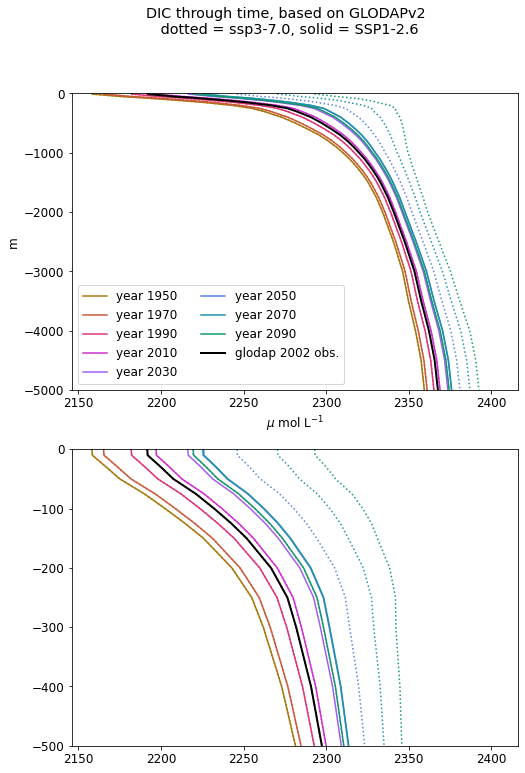

In [23]:
fact = 1.0
fig, axs = plt.subplots(2,1, figsize=(8*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#cmap = 'Spectral'
tcm = cm.phase

for i in range(0,8):
    axs[0].plot(w.DIC_ssp1[i*20,:],-w.deptht, \
                color = tcm(1.*(i)/9), label = f'year {i*20 + 1950}')
    axs[0].plot(w.DIC_ssp3[i*20,:],-w.deptht, linestyle=':',\
                color = tcm(1.*(i)/9))

axs[1].plot(TCO2_mean,-w.deptht, linestyle='-', linewidth = 2,\
                color = 'k', label = f'glodap 2002 obs.')
axs[0].plot(TCO2_mean,-w.deptht, linestyle='-', linewidth = 2,\
                color = 'k', label = f'glodap 2002 obs.')

axs[0].legend(loc = 'best', ncol = 2)


for i in range(0,8):
    axs[1].plot(w.DIC_ssp1[i*20,:],-w.deptht, \
                color = tcm(1.*(i)/9), label = f'year {i*20 + 1950}')
    axs[1].plot(w.DIC_ssp3[i*20,:],-w.deptht, linestyle=':',\
                color = tcm(1.*(i)/9), label = f'year {i*20 + 1950}')

axs[1].set_ylim([-500,0])
axs[0].set_ylim([-5000,0])
axs[0].set_xlabel('$\mu$ mol L$^{-1}$')
axs[0].set_ylabel('m')
axs[1].plot(TCO2_mean,-w.deptht, linestyle=':',\
                color = 'k', label = f'glodap 2002 observational dic')

fig.suptitle('DIC through time, based on GLODAPv2 \n dotted = ssp3-7.0, solid = SSP1-2.6')

In [17]:
from scipy.interpolate import interp1d

tmask = xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask.nc')
tmask_surf = tmask.tmask[0,0,:,:] * tmask.e1t[0,:,:] * tmask.e2t[0,:,:]

def make_yearlist_medusa(yr, scen):
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/'

    if yr < 2015:
        runid = 'bc370'
    else:
        if scen == 'ssp1':
            runid = 'be682'
        if scen == 'ssp3':
            runid = 'ce417'

    #bgc = xr.open_dataset(f'{tdir}medusa_{runid}_1y_{yr}_ptrc-T-CHLTADIC.nc')
    ts = xr.open_dataset(f'{tdir}nemo_{runid}_1y_{yr}_grid-T-TS.nc')
    #diadaux = xr.open_dataset(f'{tdir}medusa_{runid}_1y_{yr}_diad-T-aux.nc')
    
    return ts

def get_weighted(ts):
    
    T_mean = ts.votemper.isel(y=slice(0,114),deptht = 0).weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y'])
    S_mean = ts.vosaline.isel(y=slice(0,114),deptht = 0).weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y'])
    
    return T_mean, S_mean

def get_DIC_values(yr,scen, verbose = False):
    'mean dic values from glodap for a given year, scenario, and also the depth profiles/gradients'
    
    t = xr.open_dataset('./data/glodap_singledp.nc')
    if scen == 'ssp1':
        dic_dp = t.DIC_ssp1[yr-1950,:]
        surf_dic = t.DIC_ssp1[yr-1950,0]
    if scen == 'ssp3':
        dic_dp = t.DIC_ssp3[yr-1950,:]
        surf_dic = t.DIC_ssp3[yr-1950,0]

    dic_0 = dic_dp[0]
    depth_0 = t.deptht[0]
    depths_first100 = t.deptht[0:8]
    dics_first100 = dic_dp[0:8]
    f = interp1d(depths_first100, dics_first100, kind='linear')
    dic_100 = f(100)
    
    depths_second100 = t.deptht[8:11]
    dics_second100 = dic_dp[8:11]
    f = interp1d(depths_second100, dics_second100, kind='linear')
    dic_200 = f(200)

    grad_dic_0_100 = ((dic_100-dic_0)/(100-depth_0)).values
    grad_dic_0_200 = ((dic_200-dic_0)/(200-depth_0)).values

    grad_dic_100_200 = ((dic_200-dic_100)/(200-100))
    grad_avg2 = (grad_dic_100_200+grad_dic_0_100)/2
    if verbose:
        print(grad_dic_0_100)
        print(grad_dic_0_200)
        print(grad_dic_100_200)
        print(grad_avg2)
    
    dic_1000 = dic_dp[18]
    DIC_1000_minus_0 = dic_1000 - dic_0
    
    return surf_dic, grad_avg2, DIC_1000_minus_0
    
    
surf_dic, grad_avg2, DIC_1000_minus_0 = get_DIC_values(1950,'ssp1')





def get_revelle(DIC_mean, TA_mean, T_mean, S_mean):
    
    DIC = np.zeros([12]); DIC[:] = DIC_mean
    ALK = np.zeros([12]); ALK[:] = TA_mean
    votemper = T_mean
    vosaline = S_mean
    
    tdra = np.ravel(DIC * 1e-3) #DIC, convert umol/L to mol/m3 (1000 L/m3)
    ttara = np.ravel(ALK * 1e-3) #Alkalinity, convert umol/L to mol/m3 (1000 L/m3)
    tsra = np.ravel(vosaline) #salt
    tsra_psu = np.ravel(vosaline) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(votemper)

    tdepth = np.zeros_like(ttera)
    tdepth[:] = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)



    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

#     print(pco2)
#     print(BetaD)
#     BetaD = BetaD.reshape(12,114, 362)
#     BetaD[BetaD>100] = np.nan
#     Revelle = bgc.DIC.isel(y=slice(0,114),deptht = 0).copy()
#     Revelle[:] = BetaD
#     Revelle_mean = Revelle.isel(y=slice(0,114)).weighted(tmask_surf.isel(y=slice(0,114))).mean(dim = ['x','y'])

    return pco2, BetaD #Revelle_mean 


def get_all_pars(yr,scen):
    
    DIC_mean, grad_avg2, DIC_1000_minus_0 = get_DIC_values(yr,scen, verbose = False)
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/GLODAP_AnthDIC/'
    t2 = glob.glob(f'{tdir}TAlk_umolL.nc')
    Talk = xr.open_dataset(t2[0])
    TA_mean = 2349.51722732#Talk.Reconstructed_DIC[0,0:40,:].weighted(calc_ar_dar[0,0:40,:]).mean()

    ts = make_yearlist_medusa(yr, scen)
    T_mean, S_mean = get_weighted(ts)
    
    #print(f'DIC {DIC_mean.values} TA {TA_mean.values}, T {T_mean.values}, S {S_mean.values}')
    
    pco2, Revelle = get_revelle(DIC_mean, TA_mean, T_mean, S_mean)
    
    return DIC_mean, grad_avg2, DIC_1000_minus_0, TA_mean, T_mean, S_mean, pco2, Revelle
DIC_mean, grad_avg2, DIC_1000_minus_0, TA_mean, T_mean, S_mean, pco2, Revelle = \
get_all_pars(2090,'ssp3')

print(DIC_mean)
print(Revelle)

<xarray.DataArray 'DIC_ssp3' ()>
array(2293.)
Coordinates:
    year     int64 2090
    deptht   float64 0.0
Attributes:
    units:      umol/L
    long_name:  
[18.00796338 17.98221141 17.99685822 18.02938555 18.05786245 18.082601
 18.10106044 18.11337783 18.11858614 18.11457331 18.09686255 18.05401068]


In [18]:
def save_cchem_param_glodap(scen,scendez,yr):
    
    #bgc,ts, diadaux = make_yearlist(yr, scen)
    
    savenam = f'./data/cchem-param-glodap_sdp_scen-{scendez}-{yr}.nc'
    times = pd.date_range(f"{yr}/01/01",f"{yr}/12/11",freq='MS')#,closed='left')

    data_vars = {
                ### bgc gradients
        'grad_dDICdz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

                ### carbonate system variables
        'mn_kg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_SST': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_Revfact': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_DIC': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_TA': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_pCO2': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        }

    coords = {'time_counter': (['time_counter'], times),
            'quantity': (['mean', 'stdev', 'max', 'min']),

    }
    # define global attributes
    attrs = {'made in':'scratch/BOE-SOcarbon/BOE_singleDP_from_glodap.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    DIC_mean, grad_avg2, DIC_1000_minus_0, TA_mean, T_mean, S_mean, pco2, Revelle = \
    get_all_pars(yr,scen)
    
    ds['grad_dDICdz'][:,0] = grad_avg2 
    ds['grad_DIC_surfdeep'][:,0] = DIC_1000_minus_0; 
    ds['mn_kg'][:,0] = 0.065; 
    ds['mn_SST'][:,0] = T_mean.values; 
    ds['mn_Revfact'][:,0] = Revelle #.values; 
    ds['mn_DIC'][:,0] = DIC_mean#.values; 
    ds['mn_TA'][:,0] = TA_mean#.values; 
    ds['mn_pCO2'][:,0] = pco2#.values; 

    print(savenam)
    ds.to_netcdf(savenam)

    return ds
   
    
horse = True
if horse:
    for y in range(1950,2100):

        save_cchem_param_glodap('ssp1','1A',y)
        save_cchem_param_glodap('ssp3','1B',y)

./data/cchem-param-glodap_sdp_scen-1A-1950.nc
./data/cchem-param-glodap_sdp_scen-1B-1950.nc
./data/cchem-param-glodap_sdp_scen-1A-1951.nc
./data/cchem-param-glodap_sdp_scen-1B-1951.nc
./data/cchem-param-glodap_sdp_scen-1A-1952.nc
./data/cchem-param-glodap_sdp_scen-1B-1952.nc
./data/cchem-param-glodap_sdp_scen-1A-1953.nc
./data/cchem-param-glodap_sdp_scen-1B-1953.nc
./data/cchem-param-glodap_sdp_scen-1A-1954.nc
./data/cchem-param-glodap_sdp_scen-1B-1954.nc
./data/cchem-param-glodap_sdp_scen-1A-1955.nc
./data/cchem-param-glodap_sdp_scen-1B-1955.nc
./data/cchem-param-glodap_sdp_scen-1A-1956.nc
./data/cchem-param-glodap_sdp_scen-1B-1956.nc
./data/cchem-param-glodap_sdp_scen-1A-1957.nc
./data/cchem-param-glodap_sdp_scen-1B-1957.nc
./data/cchem-param-glodap_sdp_scen-1A-1958.nc
./data/cchem-param-glodap_sdp_scen-1B-1958.nc
./data/cchem-param-glodap_sdp_scen-1A-1959.nc
./data/cchem-param-glodap_sdp_scen-1B-1959.nc
./data/cchem-param-glodap_sdp_scen-1A-1960.nc
./data/cchem-param-glodap_sdp_scen

./data/cchem-param-glodap_sdp_scen-1B-2039.nc
./data/cchem-param-glodap_sdp_scen-1A-2040.nc
./data/cchem-param-glodap_sdp_scen-1B-2040.nc
./data/cchem-param-glodap_sdp_scen-1A-2041.nc
./data/cchem-param-glodap_sdp_scen-1B-2041.nc
./data/cchem-param-glodap_sdp_scen-1A-2042.nc
./data/cchem-param-glodap_sdp_scen-1B-2042.nc
./data/cchem-param-glodap_sdp_scen-1A-2043.nc
./data/cchem-param-glodap_sdp_scen-1B-2043.nc
./data/cchem-param-glodap_sdp_scen-1A-2044.nc
./data/cchem-param-glodap_sdp_scen-1B-2044.nc
./data/cchem-param-glodap_sdp_scen-1A-2045.nc
./data/cchem-param-glodap_sdp_scen-1B-2045.nc
./data/cchem-param-glodap_sdp_scen-1A-2046.nc
./data/cchem-param-glodap_sdp_scen-1B-2046.nc
./data/cchem-param-glodap_sdp_scen-1A-2047.nc
./data/cchem-param-glodap_sdp_scen-1B-2047.nc
./data/cchem-param-glodap_sdp_scen-1A-2048.nc
./data/cchem-param-glodap_sdp_scen-1B-2048.nc
./data/cchem-param-glodap_sdp_scen-1A-2049.nc
./data/cchem-param-glodap_sdp_scen-1B-2049.nc
./data/cchem-param-glodap_sdp_scen

KeyboardInterrupt: 

### looking for a seasonal cycle 

In [ ]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/DATA/GLODAPv2.2023_Merged_Master_File.csv')

In [ ]:
result = df[df['G2latitude'] <= -50]

result = result[result['G2depth'] <=10]

result = result[result['G2tco2'] >10]
result = result[result['G2talk'] >10]
result = result[result['G2tco2qc'] >0]

selected_columns_df = result[['G2year', 'G2month','G2day','G2tco2']]

In [ ]:
selected_columns_df

def proportion_of_year(month, day):
    days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    total_days_in_year = 365  # Excluding leap years

    # Calculate the total days passed until the given month and day
    total_days_passed = sum(days_in_month[:month]) + day -1

    # Calculate the proportion of the year
    proportion = total_days_passed / total_days_in_year

    return proportion

mos = selected_columns_df['G2month'].to_numpy()
days = selected_columns_df['G2day'].to_numpy()
yrs = selected_columns_df['G2year'].to_numpy()
props = np.zeros_like(yrs).astype(float)
yrsdec = np.zeros_like(yrs).astype(float)

for i in range(0,len(yrsdec)):
    
    proportion = proportion_of_year(int(mos[i]), int(days[i]))
    yrsdec[i] = yrs[i] + proportion
    props[i]

tco2 = selected_columns_df['G2tco2'].to_numpy()

In [ ]:
plt.figure()
yr = 2005 

fact = 1.0
fig, axs = plt.subplots(4,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for yr in range(2005,2021):
    filt = [(yrsdec>=yr) & (yrsdec < yr+1)]
    axs[yr-2005].plot(mos[filt],tco2[filt],'r.')
    axs[yr-2005].set_title(f'{yr}')
    axs[yr-2005].set_xlim([1,12])
    axs[yr-2005].set_xticks(np.arange(1,13,1))
    
plt.suptitle('well here are all the glodap DIC measurements ever made')
plt.tight_layout()

In [ ]:
c = result2.columns
for i in range(109):
    print(c[i])

## get model DIC seasonal cycle

In [ ]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/home/mep22dku/scratch/ModelRuns/'
tylist = make_yearlist(2010,2020,'ptrc','TOM12_TJ_RVA0',baseDir)

w = xr.open_mfdataset(tylist)

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

DIC = w.DIC.isel(deptht=0).sel(y=slice(0,37)).weighted(tmesh['csize'].sel(y=slice(0,37))).mean(dim = ['x','y'])

timec =DIC.indexes['time_counter'].to_datetimeindex()

monthlyDIC = DIC.groupby('time_counter.month').mean()


In [ ]:
fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(timec, DIC*1e6)
axs[1].plot(np.arange(1,13), monthlyDIC*1e6)
axs[2].plot(np.arange(1,13), monthlyDIC*1e6 - ((monthlyDIC*1e6).mean().values))
axs[0].set_title('DIC RIV12 A run, south of -50')
axs[1].set_title('DIC RIV12 A run, seasonal cycle')
axs[2].set_title('DIC RIV12 A run, seasonal anomaly')

plt.tight_layout()